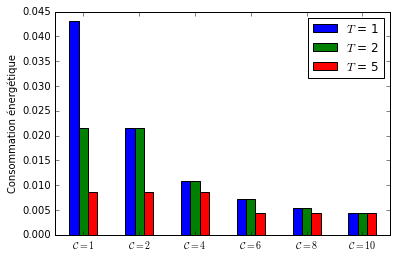

In [111]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

N = 15
ttl_array = 5 + np.zeros(N)

ttl_array_min = 1 + np.zeros(N)
ttl_array_max = 9 + np.zeros(N)

l_array = 1 + np.zeros(N)


ttl_params = np.array([1 + np.zeros(N), 
                       2 + np.zeros(N), 
                       4 + np.zeros(N),
                       6 + np.zeros(N), 
                       8 + np.zeros(N),
                       10 + np.zeros(N)])
l_params = [1, 2, 4]
df = pd.DataFrame({"$T$ = 1": [conso(g, c, 1 + np.zeros(len(g.nodes()))) 
                                     for c in ttl_params],
                   "$T$ = 2": [conso(g, c, 2. + np.zeros(len(g.nodes()))) 
                                     for c in ttl_params],
                   "$T$ = 5": [conso(g, c, 5 + np.zeros(len(g.nodes()))) 
                                     for c in ttl_params]}, 
                  index=["$\mathcal{C} = %d$" % np.mean(c) for c in ttl_params]
                 )
plt.figure()
ax = df.plot(kind="bar", rot=0)
ax.set_ylabel('Consommation énergétique')

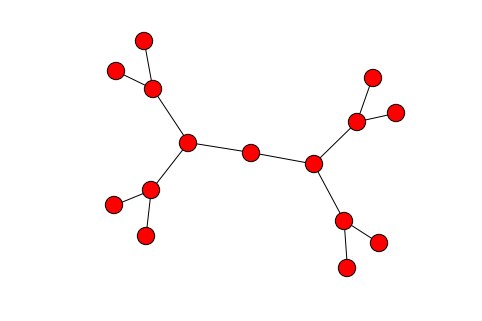

In [37]:
import networkx as nx

g = nx.balanced_tree(2, 3)
nx.draw(g)

def impact_matrix(g):
    """
    La matrice d'impact va nous donner la somme aggrégées des frequences de requetes
    admissibles pour un noeud en tenant compte des voisins.
    """
    nodes = sorted(g.nodes())
    n = len(nodes)
    adj_matrix = nx.adjacency_matrix(g, nodelist=nodes).T
    return ((np.identity(n) - adj_matrix) ** (-1))

def ratio(c, t):
    if t <= c:
        return np.ceil(c / t) * t
    else:
        return t                                                                                                                                                                                                    
rfunc = np.vectorize(ratio)

In [56]:
def conso(g, C, t_request,
             L_get=87 * 8, L_Ans=96 * 8):

    # Settings
    Vdd = 3
    I_tx = 11.6e-3
    I_sleep = 80e-9
    I_idle = 396e-6
    I_rx = 12.7e-3
    I_sleep_idle = 691e-12
    I_idle_tx = 6.63e-6
    I_idle_rx = 6.63e-6
    P_tx = I_tx * Vdd
    P_sleep = I_sleep * Vdd
    P_idle = I_idle * Vdd
    P_rx = I_rx * Vdd

    Energy = Vdd * 3 * 3600

    # Communications settings
    R = 250000
    #L_get = 87 * 8
    #L_Ans = 96 * 8
    S_get = L_get / R
    S_Ans = L_Ans / R
    S_ack = 0.608e-3
    S_get_Rxtx = S_ack
    S_Ans_Rxtx = S_ack
    T_period = 0.244
    T_d = 0.16e-3
    T_p = 0.4e-3

    t_act = 4e-4
    t_sleep = T_period - t_act

    S_get_Rxrx = (3 * S_get) / 2 + T_p
    S_Ans_Rxrx = (3 * S_Ans) / 2 + T_p
    S_Ans_Txrx = (3 + np.floor((t_sleep - S_Ans) / S_Ans)) * T_d / 2 + S_ack
    S_get_Txrx = (3 + np.floor((t_sleep - S_get) / S_get)) * T_d / 2 + S_ack
    S_Ans_Txtx = (3 + np.floor((t_sleep - S_Ans) / S_Ans)) * S_Ans / 2
    S_get_Txtx = (3 + np.floor((t_sleep - S_get) / S_get)) * S_get / 2

    gamma_rx_get = P_sleep * (3 * S_get / 2 + T_p + S_ack) / T_period
    gamma_rx_Ans = P_sleep * (3 * S_Ans / 2 + T_p + S_ack) / T_period
    gamma_tx_get = P_sleep * ((3 + np.floor((t_sleep-S_get)/S_get))/2*(S_get+T_d) + S_ack) / T_period
    gamma_tx_Ans = P_sleep * ((3 + np.floor((t_sleep-S_Ans)/S_Ans))/2*(S_Ans+T_d) + S_ack) / T_period

    omega_sleep = P_sleep * t_sleep / T_period\
                - gamma_tx_Ans - gamma_rx_Ans\
                - gamma_rx_get - gamma_tx_get
    omega_cl = t_act * P_rx / T_period

    mat = impact_matrix(g)
    N = len(g.nodes())
    r = rfunc(C, t_request)

    omega_CoAP_rx = (P_tx * S_get_Rxrx + P_rx * S_get_Rxtx) / r
    omega_CoAP_tx = (P_tx * S_Ans_Txtx + P_rx * S_Ans_Txrx) / r

    # On calcule les couts de retransmission en utilisant la matrice d'impact
    omega_forward_rx = mat.dot(omega_CoAP_rx)
    omega_forward_tx = mat.dot(omega_CoAP_tx)

    omega_tot = (omega_sleep + omega_cl\
                + omega_CoAP_tx + omega_CoAP_rx\
                + omega_forward_rx\
                + omega_forward_tx)

    return np.mean(omega_tot)

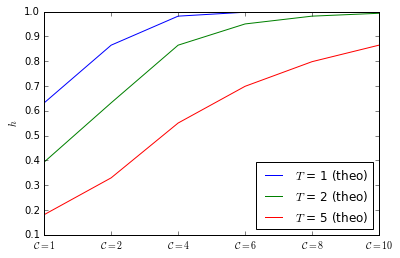

In [112]:
df_hit = pd.DataFrame(
    {"$T$ = 1 (theo)": [1 - np.exp(-np.mean(c)/1) for c in ttl_params],
     "$T$ = 2 (theo)": [1 - np.exp(-np.mean(c)/2) for c in ttl_params],
     "$T$ = 5 (theo)": [1 - np.exp(-np.mean(c)/5) for c in ttl_params]},
    index=["$\mathcal{C} = %d$" % np.mean(c) for c in ttl_params]
)
plt.figure()
ax = df_hit.plot(rot=0)
ax.set_ylabel('$h$')